In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [64]:
dataset = pd.read_csv('diabetes.csv', delimiter=',')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Exploratory Data Analysis

In [58]:
print(dataset.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [59]:
print(dataset.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


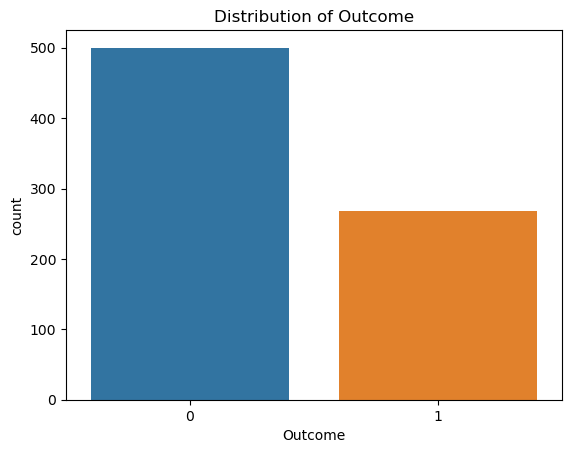

In [61]:
sns.countplot(x='Outcome', data=dataset)
plt.title('Distribution of Outcome')
plt.show()

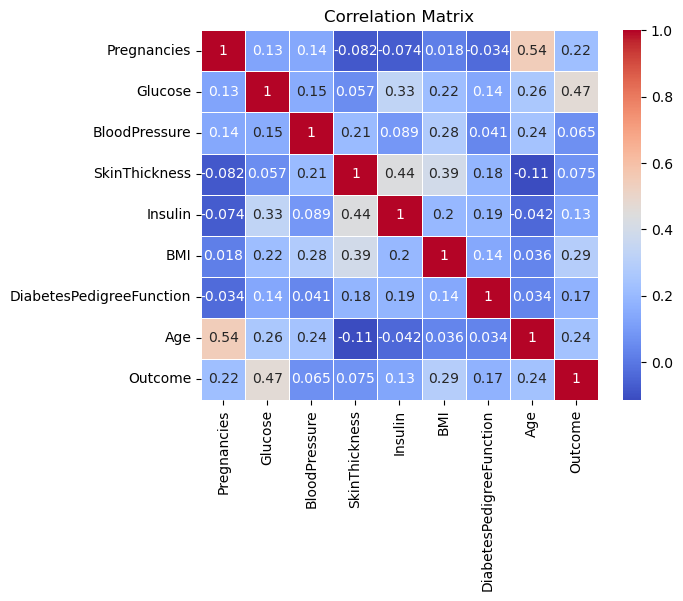

In [62]:
correlation_matrix = dataset.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

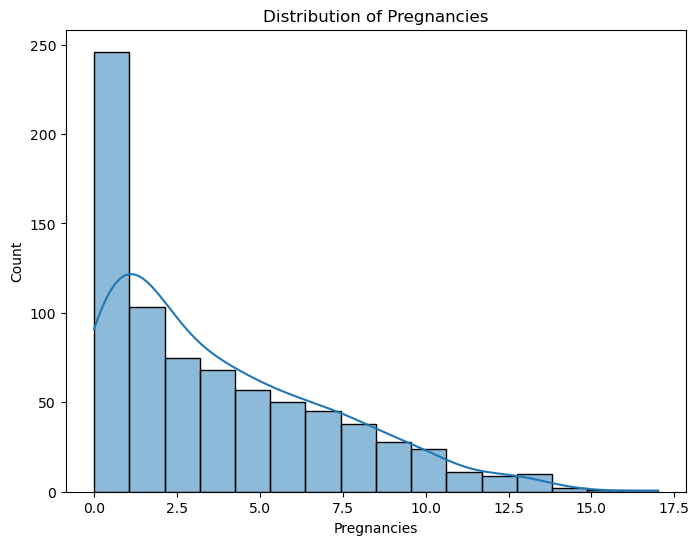

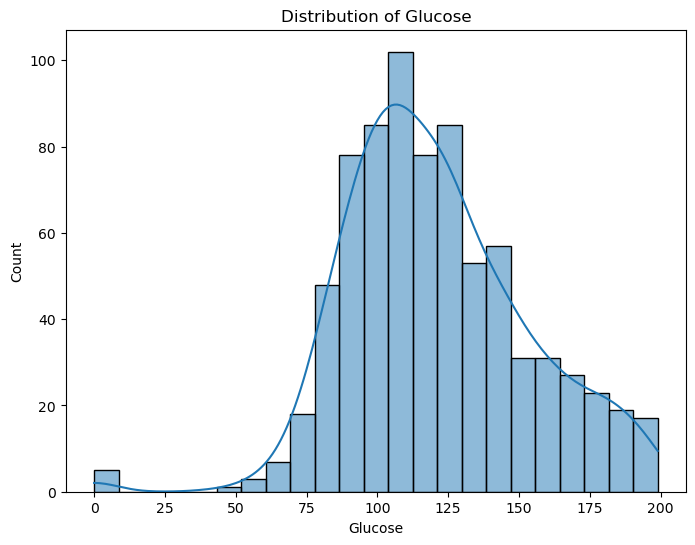

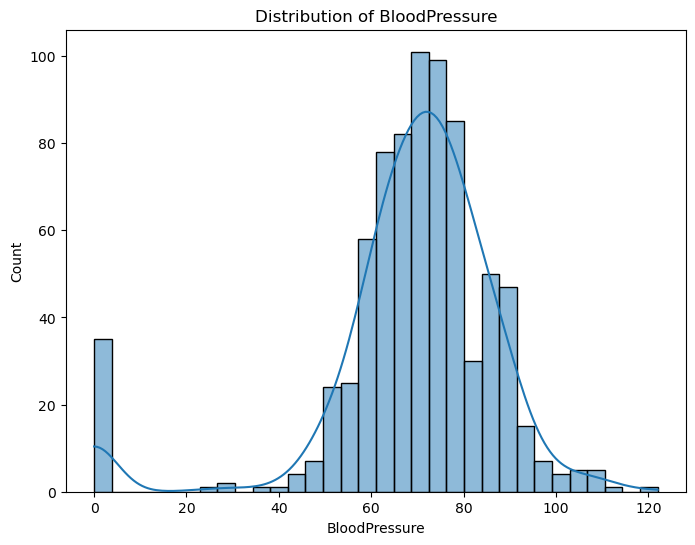

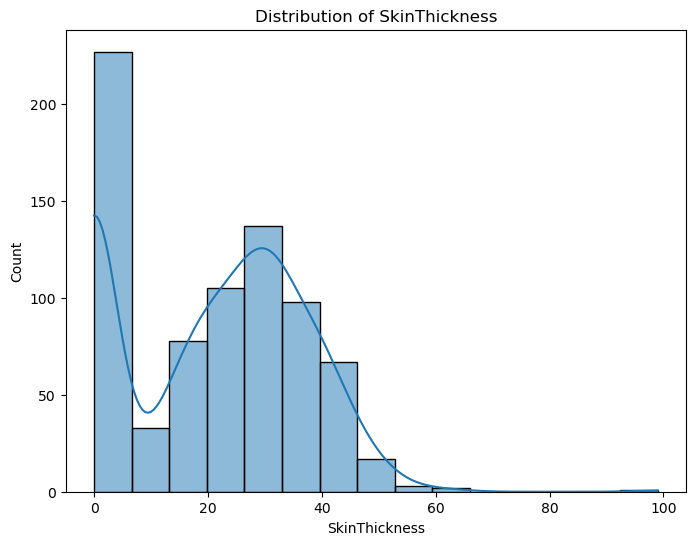

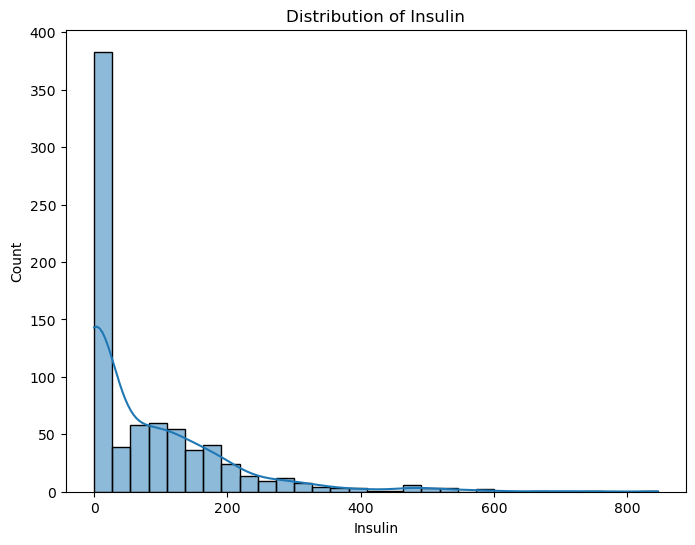

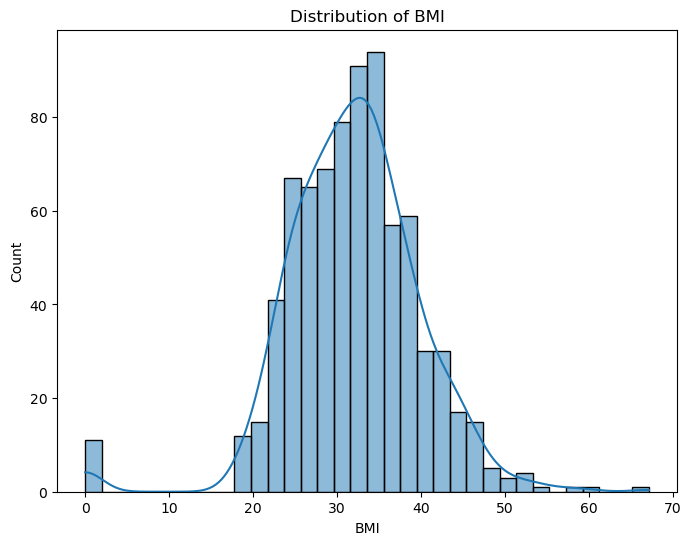

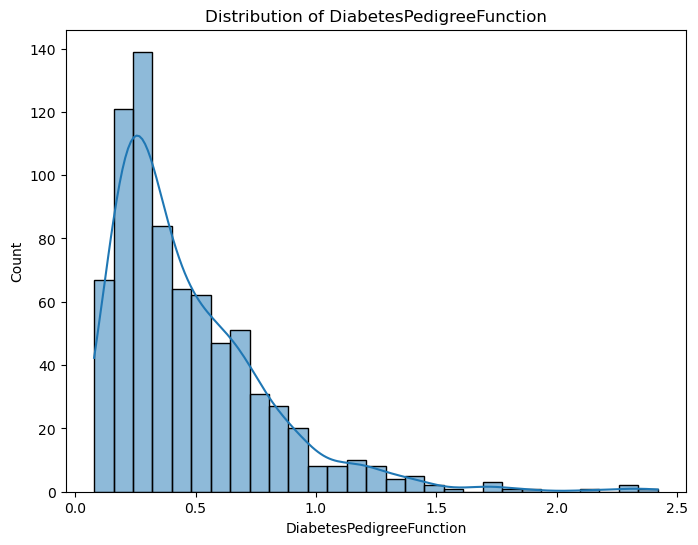

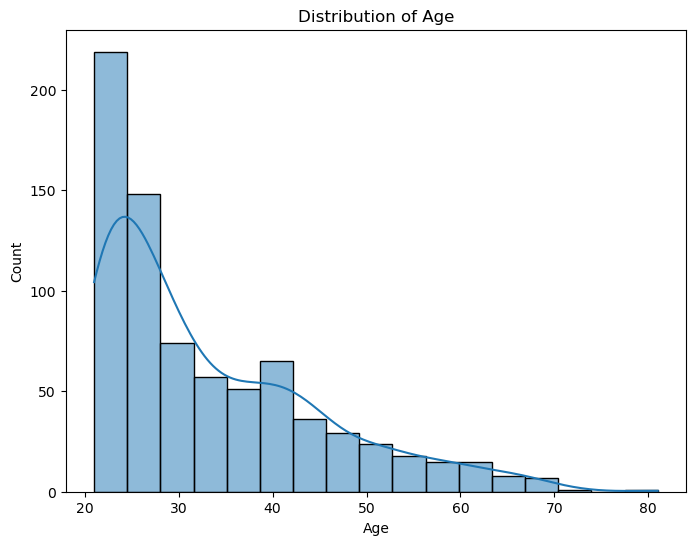

In [63]:
features = dataset.columns[:-1]

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=dataset, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


### Train-val-test split

In [28]:
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]


In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Normalization

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Model training

In [32]:
model = Sequential()
model.add(Dense(64, input_shape=(8,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=150, batch_size=10, validation_data=(X_val, y_val))

Epoch 1/150
46/46 [==============================] - 1s 6ms/step - loss: 0.7065 - accuracy: 0.5370 - val_loss: 0.6400 - val_accuracy: 0.7078
Epoch 2/150
46/46 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6522 - val_loss: 0.5888 - val_accuracy: 0.7532
Epoch 3/150
46/46 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.7000 - val_loss: 0.5423 - val_accuracy: 0.7792
Epoch 4/150
46/46 [==============================] - 0s 3ms/step - loss: 0.5788 - accuracy: 0.7000 - val_loss: 0.5104 - val_accuracy: 0.7987
Epoch 5/150
46/46 [==============================] - 0s 3ms/step - loss: 0.5477 - accuracy: 0.7152 - val_loss: 0.4889 - val_accuracy: 0.7987
Epoch 6/150
46/46 [==============================] - 0s 3ms/step - loss: 0.5570 - accuracy: 0.7130 - val_loss: 0.4753 - val_accuracy: 0.7922
Epoch 7/150
46/46 [==============================] - 0s 2ms/step - loss: 0.5143 - accuracy: 0.7543 - val_loss: 0.4796 - val_accuracy: 0.7727
Epoch 8/150
4

### Accuracy

In [34]:
_, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f%%' % (accuracy * 100))

5/5 [==============================] - 0s 2ms/step - loss: 0.5503 - accuracy: 0.7987
Test Accuracy: 79.87%


# LIME

In [89]:
from scipy.spatial.distance import euclidean
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

1st instance

In [90]:
instance_to_explain = X_test[1]

In [91]:
def generate_perturbed_instances(instance, num_samples=1000, perturbation_scale=0.1):
    perturbed_instances = []
    
    for _ in range(num_samples):
        perturbation = np.random.normal(0, perturbation_scale, size=instance.shape)
        perturbed_instance = instance + perturbation
        perturbed_instances.append(perturbed_instance)
    
    return np.array(perturbed_instances)

In [92]:
def lime_explanation(instance, interpretable_model, num_samples=1000, perturbation_scale=0.1):
    perturbed_instances = generate_perturbed_instances(instance, num_samples, perturbation_scale)
    perturbed_distances = np.linalg.norm(perturbed_instances - instance, axis=1)
    
    perturbed_predictions = model.predict(perturbed_instances)
    weights = np.exp(-perturbed_distances)
    
    interpretable_model.fit(perturbed_instances, perturbed_predictions, sample_weight=weights)
    
    return interpretable_model.coef_

In [93]:
lime_weights_1 = lime_explanation(instance_to_explain, Ridge()) 
print("LIME_1 Feature Weights:", lime_weights_1)

32/32 [==============================] - 0s 1ms/step
LIME_1 Feature Weights: [[-0.2085383   0.31814143 -0.02058433 -0.24037817  0.19847317  0.50677894
   0.09170566 -0.22943486]]


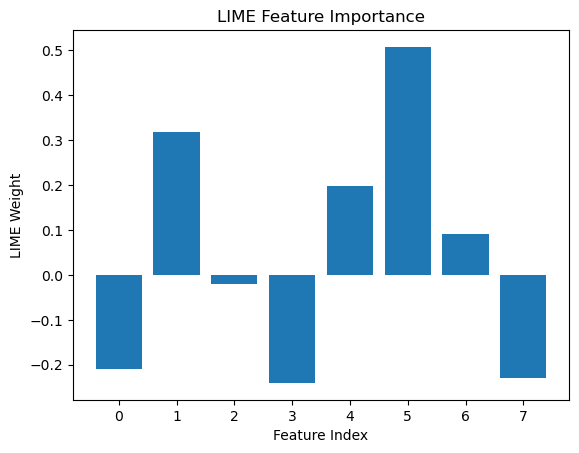

In [94]:
lime_weights_flat_1 = lime_weights_1.flatten()

plt.bar(range(len(lime_weights_flat_1)), lime_weights_flat_1)
plt.xlabel('Feature Index')
plt.ylabel('LIME Weight')
plt.title('LIME Feature Importance')
plt.show()


In [95]:
lime_weights_2 = lime_explanation(instance_to_explain, LinearRegression())  

print("LIME Feature Weights:", lime_weights_2)

32/32 [==============================] - 0s 1ms/step
LIME Feature Weights: [[-0.24013939  0.37088224 -0.03268738 -0.26127317  0.23510212  0.57212438
   0.10420169 -0.25068867]]


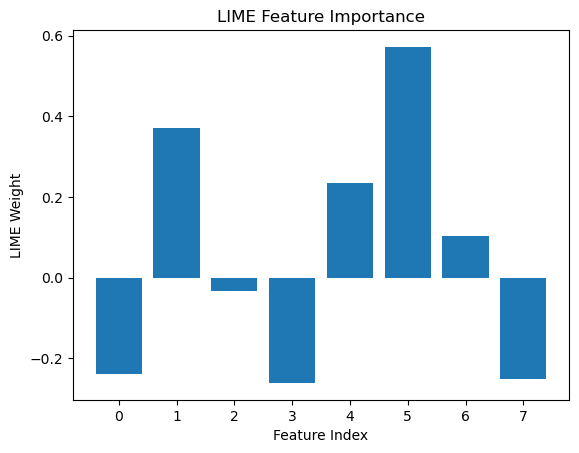

In [96]:
lime_weights_flat_2 = lime_weights_2.flatten()

plt.bar(range(len(lime_weights_flat_2)), lime_weights_flat_2)
plt.xlabel('Feature Index')
plt.ylabel('LIME Weight')
plt.title('LIME Feature Importance')
plt.show()

In [97]:
lime_weights_3 = lime_explanation(instance_to_explain, Ridge(), num_samples=10000)  

print("LIME Feature Weights:", lime_weights_3)

313/313 [==============================] - 1s 2ms/step
LIME Feature Weights: [[-0.22804844  0.35567927 -0.03561405 -0.25649934  0.22367757  0.55561293
   0.10930845 -0.2500854 ]]


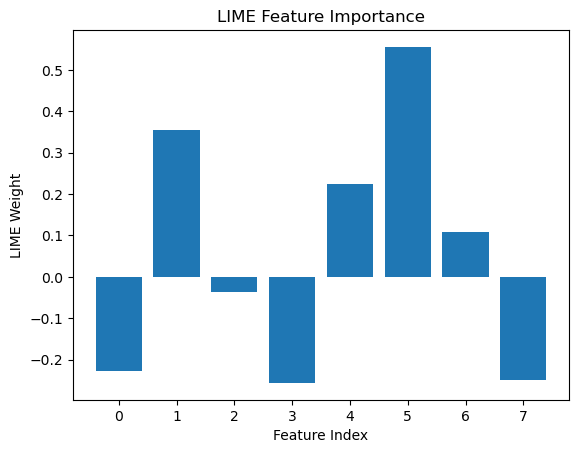

In [98]:
lime_weights_flat_3 = lime_weights_3.flatten()

plt.bar(range(len(lime_weights_flat_3)), lime_weights_flat_3)
plt.xlabel('Feature Index')
plt.ylabel('LIME Weight')
plt.title('LIME Feature Importance')
plt.show()

In [99]:
def lime_explanation(instance, interpretable_model, num_samples=1000, perturbation_scale=0.1):
    perturbed_instances = generate_perturbed_instances(instance, num_samples, perturbation_scale)
   
    dot_products = np.sum(perturbed_instances * instance, axis=1)
    norms = np.linalg.norm(perturbed_instances, axis=1) * np.linalg.norm(instance)
    cosine_similarities = dot_products / norms
 
    perturbed_distances = 1 - cosine_similarities
    
    perturbed_predictions = model.predict(perturbed_instances)

    weights = np.exp(-perturbed_distances)
    
    interpretable_model.fit(perturbed_instances, perturbed_predictions, sample_weight=weights)
    
    return interpretable_model.coef_


In [100]:
lime_weights_4 = lime_explanation(instance_to_explain, Ridge()) 

print("LIME Feature Weights:", lime_weights_4)

32/32 [==============================] - 0s 3ms/step
LIME Feature Weights: [[-0.19566458  0.31251763 -0.02664643 -0.22692088  0.19357023  0.48904837
   0.0906687  -0.22733926]]


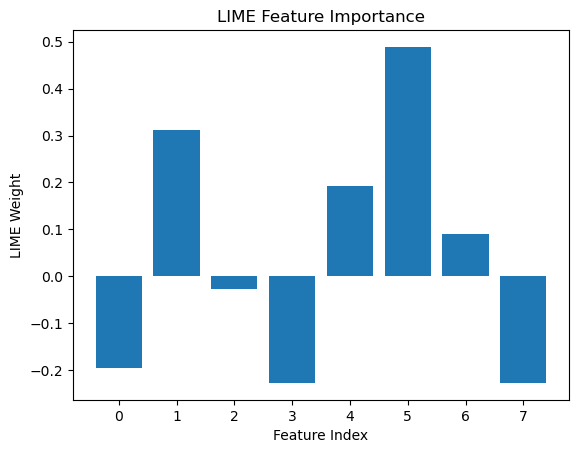

In [101]:
lime_weights_flat_4 = lime_weights_4.flatten()

plt.bar(range(len(lime_weights_flat_4)), lime_weights_flat_4)
plt.xlabel('Feature Index')
plt.ylabel('LIME Weight')
plt.title('LIME Feature Importance')
plt.show()

In [102]:
lime_weights_5 = lime_explanation(instance_to_explain, LinearRegression())  

print("LIME Feature Weights:", lime_weights_5)

32/32 [==============================] - 0s 2ms/step
LIME Feature Weights: [[-0.23398223  0.35349011 -0.03610874 -0.25682798  0.22445371  0.56035446
   0.10362479 -0.2467442 ]]


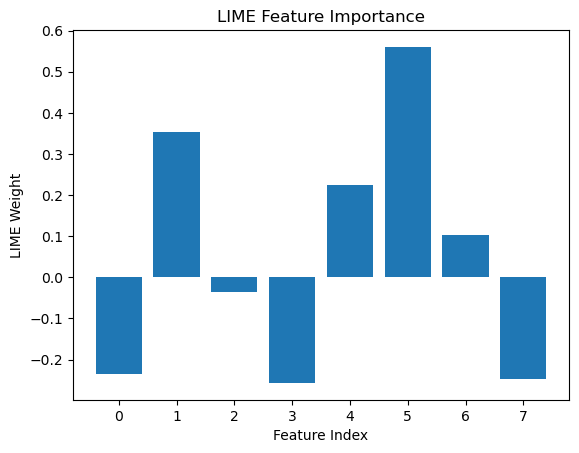

In [103]:
lime_weights_flat_5 = lime_weights_5.flatten()

plt.bar(range(len(lime_weights_flat_5)), lime_weights_flat_5)
plt.xlabel('Feature Index')
plt.ylabel('LIME Weight')
plt.title('LIME Feature Importance')
plt.show()

# SHAP

In [121]:
import itertools

In [127]:
def factorial(n):
    if n == 0 or n == 1:
        return 1
    return n * factorial(n - 1)

In [128]:
def binomial_coefficient(n, k):
    return factorial(n) / (factorial(k) * factorial(n - k))

In [130]:
def calculate_shapley_value(instance, model, feature_index, perturbation_scale):
    num_features = len(instance)
    shapley_value = 0.0

    for coalition_size in range(num_features + 1):
        for coalition in itertools.combinations(range(num_features), coalition_size):
            if feature_index in coalition:

                marginal_contribution = model.predict(np.array([instance]))[0] - model.predict(np.array([instance_at_coalition(coalition, instance, feature_index, perturbation_scale)]))[0]

                weight = binomial_coefficient(num_features - 1, coalition_size - 1) / 2**num_features

                shapley_value += weight * marginal_contribution

    return shapley_value

In [131]:
def instance_at_coalition(coalition, instance, feature_index, perturbation_scale):
    perturbed_instance = np.array(instance)
    for i in coalition:
        perturbed_instance[i] = np.random.normal(0, perturbation_scale)
    perturbed_instance[feature_index] = instance[feature_index]
    return perturbed_instance

In [132]:
shapley_values = []
perturbation_scale = 0.1

In [133]:
for feature_index in range(len(instance_to_explain)):
    shapley_value = calculate_shapley_value(instance_to_explain, model, feature_index, perturbation_scale)
    shapley_values.append(shapley_value)

print("SHAP Feature Values:", shapley_values)

1/1 [==============================] - 0s 21ms/step
SHAP Feature Values: [array([-0.48327094], dtype=float32), array([-1.911834], dtype=float32), array([-0.45763573], dtype=float32), array([-1.3350862], dtype=float32), array([-0.57752204], dtype=float32), array([-1.0237732], dtype=float32), array([-0.229985], dtype=float32), array([0.3278503], dtype=float32)]


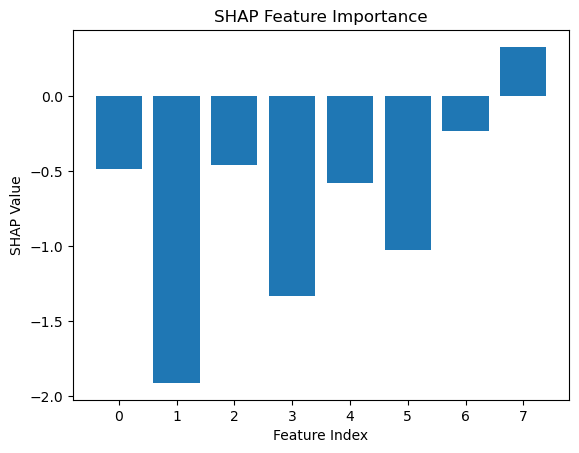

In [134]:
shapley_values_array = np.array(shapley_values)
plt.bar(range(len(shapley_values_array)), shapley_values_array.flatten())
plt.xlabel('Feature Index')
plt.ylabel('SHAP Value')
plt.title('SHAP Feature Importance')
plt.show()

In [135]:
shapley_values = []
perturbation_scale = 0.05

In [136]:
for feature_index in range(len(instance_to_explain)):
    shapley_value = calculate_shapley_value(instance_to_explain, model, feature_index, perturbation_scale)
    shapley_values.append(shapley_value)

print("SHAP Feature Values:", shapley_values)

1/1 [==============================] - 0s 22ms/step
SHAP Feature Values: [array([-0.48161572], dtype=float32), array([-1.8929055], dtype=float32), array([-0.5015372], dtype=float32), array([-1.2714599], dtype=float32), array([-0.5868987], dtype=float32), array([-1.0350531], dtype=float32), array([-0.26518995], dtype=float32), array([0.32138693], dtype=float32)]


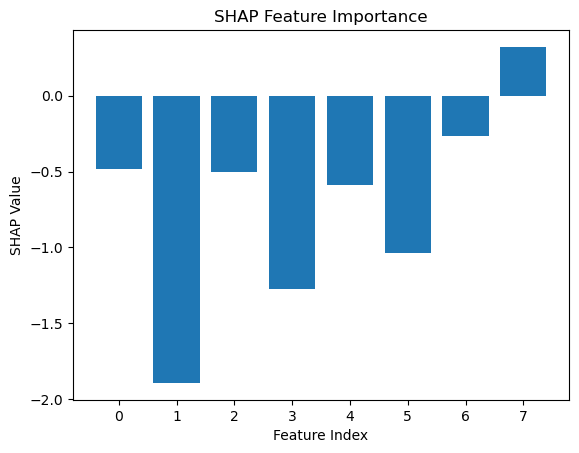

In [137]:
shapley_values_array = np.array(shapley_values)
plt.bar(range(len(shapley_values_array)), shapley_values_array.flatten())
plt.xlabel('Feature Index')
plt.ylabel('SHAP Value')
plt.title('SHAP Feature Importance')
plt.show()